## Some theories
* We want to automatically ignore low-risk entries. They should be forced to the bottom of our analysis.
* We want to highlight entries that flag "alarms" for the different analysts.
* Guns that are severely underpriced are scams or are deliberately mislabeled. [For instance.](http://www.armslist.com/posts/4747290/lima-ohio-shotguns-for-sale-trade--hoyt-)
* Guns that are severely overpriced may be general signals of willingness to deal with large amounts of cash, or large numbers of transactions. [For instance.](http://www.armslist.com/posts/4746478/west-virginia-handguns-want-to-buy--colt-pistols-and-revolvers)

So: Assuming that we can partition guns into distinct groups based on their prices, we can 

We primarily have price and weapons extractions available to us from armslist. (Soon we'll have price extractions from other sites, but not at this time. In practice, this means that we're really presenting some acceptable price ranges for arms list.

## Data prep (in which assumptions are encoded)

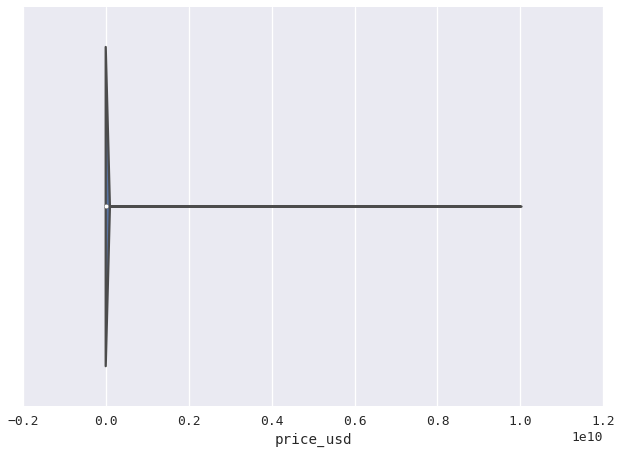

In [1]:
# We actually elide a lot of that here...

%matplotlib inline
sns.set(context='talk', font='monospace')
df = pd.read_pickle('../armslist_data.pkl')
sns.violinplot(df.price_usd)

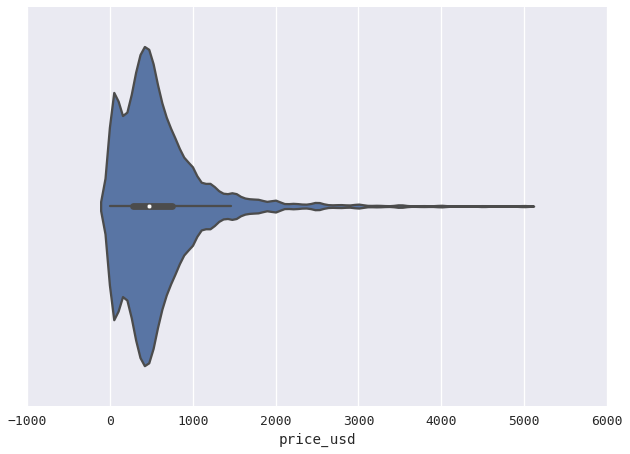

In [2]:
# Two crude price cutoffs
high_price = 5000
low_price = 2
df = df.ix[(df.price_usd <= high_price) & (df.price_usd >= low_price)]
sns.violinplot(df.price_usd)

In [13]:
def get_gun_price_range_dict(df, min_guns=50, prioritize_manufacturer=True, json_write_path=None):
    """
    Helper function for generating gun stats
    :param pandas.DataFrame df: DataFrame of guns.
    :param min_guns: minimum count of guns required by a manufacturer
    :param prioritize_manufacturer: if True, prioritize manfacturer over caliber
    :returns tuple: Dataframe of descriptions, Dictionary with lookups of mins and maxes
    """
    tier_one = 'manufacturer'
    tier_two = 'caliber'
    if prioritize_manufacturer is False:
        tier_one = 'caliber'
        tier_two = 'manufacturer'
    
    cur_df = df.copy().ix[:, [tier_one, tier_two, 'price_usd']]
    cur_df.ix[:, tier_one] = cur_df[tier_one].astype(str)
    cur_df.ix[:, tier_two] = cur_df[tier_two].astype(str)
    
    default_gun = cur_df.price_usd.describe()
    default_gun[tier_one] = '?'
    default_gun[tier_two] = '?'
    tier_one_defaults = cur_df.ix[cur_df[tier_one].apply(lambda x: x not in ['?', '']),
                                  [tier_one, 'price_usd']
                                 ].groupby(tier_one).describe().unstack()
    tier_one_defaults.columns = tier_one_defaults.columns.get_level_values(1)
    tier_one_defaults = tier_one_defaults.ix[tier_one_defaults['count'] >= min_guns, :].reset_index()
    tier_one_defaults[tier_two] = '?'

    tier_one_set = set(tier_one_defaults[tier_one])
    tier_one_slice = cur_df.ix[cur_df[tier_one].apply(lambda x: x in tier_one_set), :]
    
    t_one_plot = sns.boxplot(x=tier_one, y='price_usd', data=tier_one_slice)
    t_one_plot.set_xticklabels(t_one_plot.get_xticklabels(), rotation=40)
    
    tier_two_values = tier_one_slice.groupby([tier_one, tier_two]).describe().unstack(2)
    tier_two_values.columns = tier_two_values.columns.get_level_values(1)
    tier_two_values = tier_two_values.ix[tier_two_values['count'] >= min_guns, :].reset_index()
    tier_two_values = tier_two_values.ix[tier_two_values[tier_two].apply(lambda x: x not in ['?', '']), :]
    
    # t_two_plot = sns.boxplot(x=tier_one, y='price_usd', hue=tier_two, data=tier_two_values)
    # t_two_plot.set_xticklabels(t_two_plot.get_xticklabels(), rotation=40)
                       
    describe_df = pd.concat([tier_one_defaults, tier_two_values]).append(default_gun.T).reset_index(drop=True)
    describe_df['lower_bound'] = describe_df.apply(lambda x: x['mean'] - 2*x['std'], axis=1)
    describe_df['upper_bound'] = describe_df.apply(lambda x: x['mean'] + 2*x['std'], axis=1)
    describe_df = describe_df.ix[:, ['manufacturer', 'caliber', 'count',
                                     'mean', 'std',
                                     'min', 'lower_bound', '25%', '50%', '75%', 'upper_bound', 'max']]
    describe_df.sort_values(['manufacturer', 'caliber', 'count'], ascending=[True, True, False], inplace=True)
    
    lookup_dict = describe_df.set_index([tier_one, tier_two]).ix[:, ['lower_bound', 'upper_bound']].to_dict('index')
    return describe_df, lookup_dict

## Gun Types and Price Ranges

For a given manufacturer's make and model of gun, it'd be useful to know for how much it retails on the site. If we don't have enough data, we can lump the gun into a generic bucket and classify it with all of the other of the same type.

Each of these investigations should be confined to the somewhat loose schema developed for the first challenge problem:

**First List**
* Handgun
* Shotgun
* Rifle
* ~~Machine Gun~~

**Second List**
* AR (rifle)
* AK (rifle)
* FN FAL (rifle)
* Uzi (submachine gun)
* Glock (Handgun)
* Desert Eagle (Handgun)
* FN 5.7 (Handgun)
* 1911 (Handgun)
* Revolver (Handgun)

## First List
### Handguns

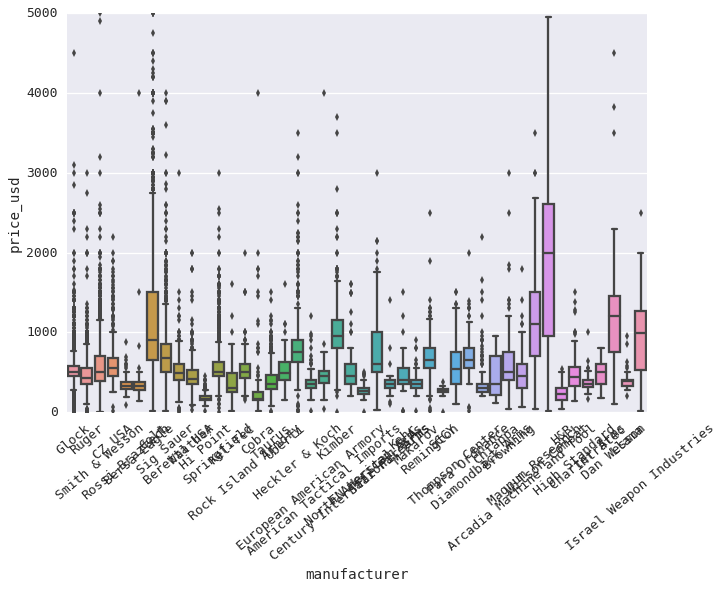

In [23]:
describe_df, handgun_dict = get_gun_price_range_dict(
    df.ix[(df.category_2 == 'Handguns') & (df.category_3 != 'Suppressors'), :])

In [ ]:
describe_df.shape

### Shotguns

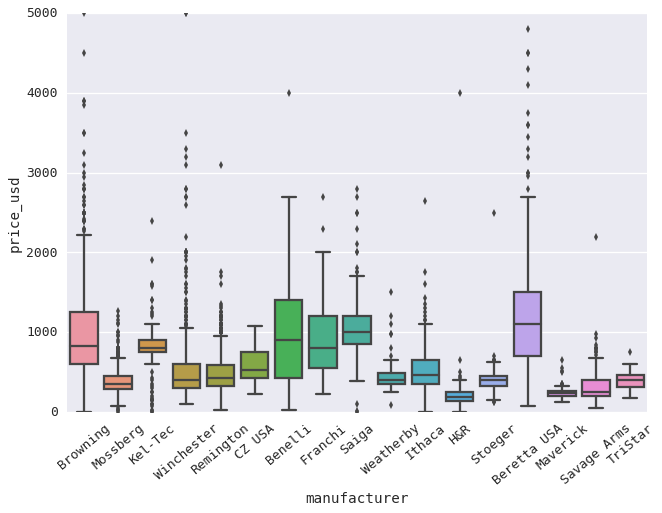

In [6]:
describe_df, shotgun_dict = get_gun_price_range_dict(df.ix[df.category_3=='Shotgun', :])

In [ ]:
describe_df.shape

### Rifles

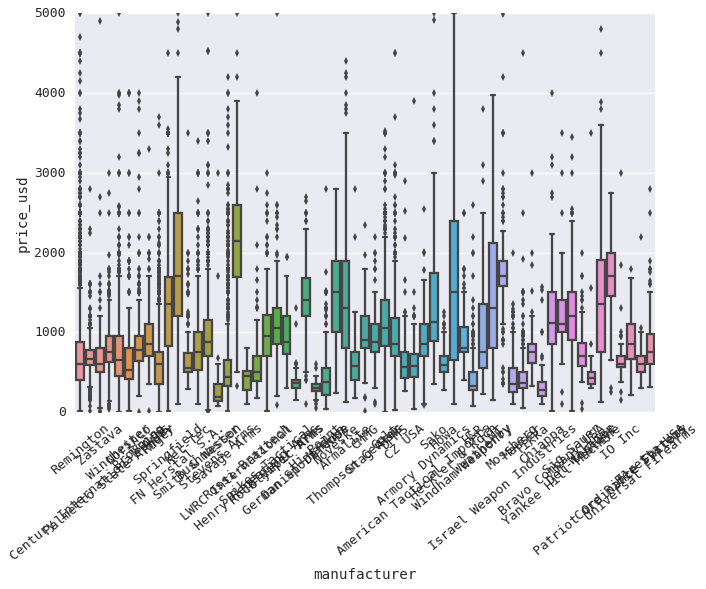

In [24]:
describe_df, rifle_dict = get_gun_price_range_dict(df.ix[df.category_3 == 'Rifle', :])

In [ ]:
describe_df.shape

## Second List
### Glock

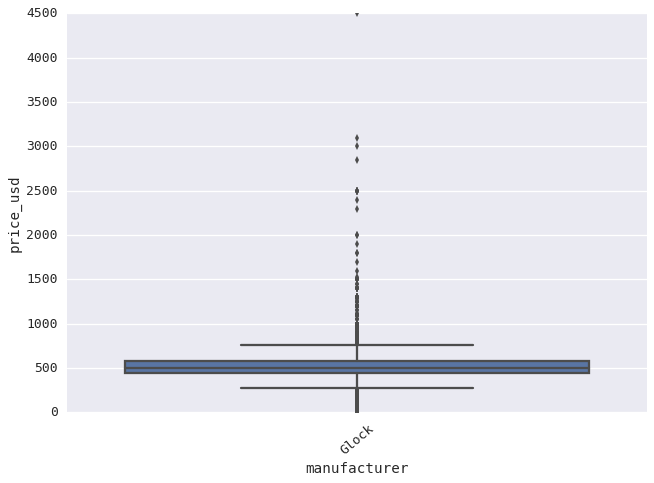

In [25]:
describe_df, glock_dict = get_gun_price_range_dict(df.ix[df.manufacturer == 'Glock', :])

In [ ]:
describe_df.shape

### Desert Eagle (Well, sort of...)

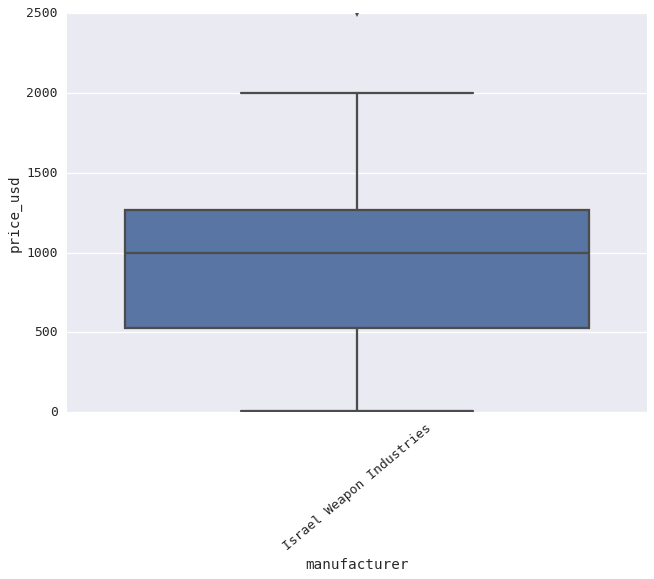

In [33]:
describe_df, deagle_dict = get_gun_price_range_dict(df.ix[(df.category_2 == 'Handguns') &
                                                          (df.manufacturer == 'Israel Weapon Industries'),
                                                          :])

In [34]:
describe_df

,manufacturer,caliber,count,mean,std,min,lower_bound,25%,50%,75%,upper_bound,max
1,?,?,71,940.183099,505.948002,10,-71.712905,525,995,1269.5,1952.079102,2500
0,Israel Weapon Industries,?,71,940.183099,505.948002,10,-71.712905,525,995,1269.5,1952.079102,2500


### Revolver

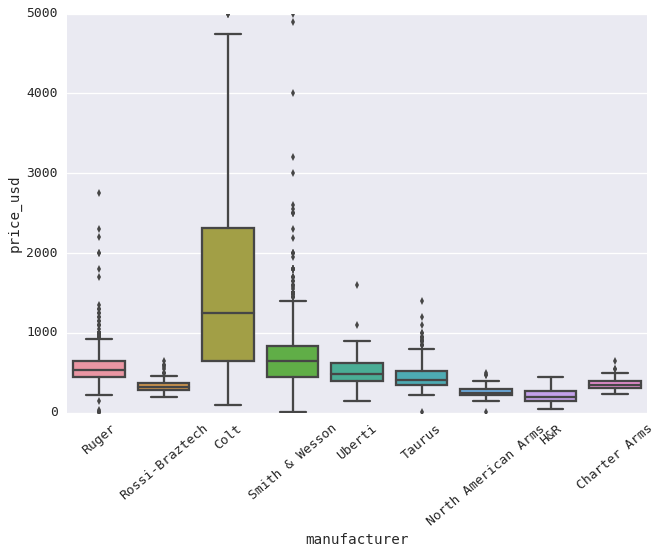

In [26]:
describe_df, revolver_dict = get_gun_price_range_dict(df.ix[df.category_3 == 'Revolver', :])

In [19]:
describe_df.shape

(8, 12)

# Evaluations...

But how well do these threshold values work on the *scored* armslist data?

In [49]:
def kappa(a,b,c,d):
    tot = a + b + c + d
    Pa  = float(a + d)/tot
    PA1 = float(a + b)/tot
    PA2 = 1.0- PA1
    PB1 = float(a + c) /tot
    PB2 = 1.0 -PB1
    Pe  = PA1 *PB1 + PA2*PB2
    print(Pa, PA1, PB1, PA2, PB2)
    return (Pa -Pe)/ (1.0 -Pe)

def check_price_for_key(x, check_dict):
    cur_key = (x['manufacturer'], x['caliber'])
    if cur_key not in check_dict:
        cur_key = (x['manufacturer'], '?')
        if cur_key not in check_dict:
            cur_key = ('?','?')
        
    normalized = (1.*x['price_usd'] - check_dict[cur_key]['lower_bound'])/check_dict[cur_key]['upper_bound']
    normalized = max(0., min(1.0, normalized))
    if normalized == 1.:
        return 'medium_or_high'
    return 'low'

In [48]:
cp2_df = pd.read_pickle('../cp2_data.pkl')
handgun_test = cp2_df.ix[(cp2_df.category_2 == 'Handguns') & (cp2_df.category_3 != 'Suppressors'),
                         ['manufacturer', 'caliber', 'price_usd', 'simple_risk_profile']].dropna()
shot_test = cp2_df.ix[(cp2_df.category_3=='Shotgun'),
                      ['manufacturer', 'caliber', 'price_usd', 'simple_risk_profile']].dropna()
rifle_test = cp2_df.ix[cp2_df.category_3 == 'Rifle',
                       ['manufacturer', 'caliber', 'price_usd', 'simple_risk_profile']].dropna()
glock_test = cp2_df.ix[cp2_df.manufacturer == 'Glock',
                       ['manufacturer', 'caliber', 'price_usd', 'simple_risk_profile']].dropna()
deagle_test = cp2_df.ix[(cp2_df.category_2 == 'Handguns') & (cp2_df.manufacturer == 'Israel Weapon Industries'),
                        ['manufacturer', 'caliber', 'price_usd', 'simple_risk_profile']].dropna()
rev_test = cp2_df.ix[(cp2_df.category_3=='Revolver'),
                     ['manufacturer', 'caliber', 'price_usd', 'simple_risk_profile']].dropna()

In [65]:
handgun_test['risk_by_price'] = handgun_test.apply(lambda x: check_price_for_key(x, handgun_dict), axis=1)
pd.crosstab(handgun_test.risk_by_price, handgun_test.simple_risk_profile)

simple_risk_profile,low,medium_or_high
risk_by_price,,
low,409,21
medium_or_high,25,3


In [66]:
shot_test['risk_by_price'] = shot_test.apply(lambda x: check_price_for_key(x, shotgun_dict), axis=1)
pd.crosstab(shot_test['risk_by_price'], shot_test['simple_risk_profile'])

simple_risk_profile,low,medium_or_high
risk_by_price,,
low,79,4
medium_or_high,4,1


In [67]:
rifle_test['risk_by_price'] = rifle_test.apply(lambda x: check_price_for_key(x, rifle_dict), axis=1)
pd.crosstab(rifle_test['risk_by_price'], rifle_test['simple_risk_profile'])

simple_risk_profile,low,medium_or_high
risk_by_price,,
low,318,21
medium_or_high,22,2


In [68]:
glock_test['risk_by_price'] = glock_test.apply(lambda x: check_price_for_key(x, glock_dict), axis=1)
pd.crosstab(glock_test['risk_by_price'], glock_test['simple_risk_profile'])

simple_risk_profile,low,medium_or_high
risk_by_price,,
low,58,5


In [69]:
deagle_test['risk_by_price'] = deagle_test.apply(lambda x: check_price_for_key(x, deagle_dict), axis=1)
pd.crosstab(deagle_test['risk_by_price'], deagle_test['simple_risk_profile'])

simple_risk_profile,low
risk_by_price,
low,1


In [71]:
rev_test['risk_by_price'] = rev_test.apply(lambda x: check_price_for_key(x, revolver_dict), axis=1)
pd.crosstab(rev_test['risk_by_price'], rev_test['simple_risk_profile'])

simple_risk_profile,low,medium_or_high
risk_by_price,,
low,80,3
medium_or_high,4,1
